In [39]:
import itertools
import numpy as np
import scipy as sc
import matplotlib
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

#Input data for 2014 (TI4)

TI4_data = np.genfromtxt('TI4_data.csv',delimiter=',')
#TI4_data = np.genfromtxt('TI5_data.csv',delimiter=',')
#TI4_data


In [40]:
# A few function definitions to model data with
# Implies a logarithmic model of the form d + b log (ax+c)

def base_log_func(x,a,b,c):
  """
  Base log function to fit data from day 1. 
  Implies the prizepool starts at 1.6M USD
  """
  return 1.6 + b * np.log(a * x + c)

def log_func(x,a,b,c,d):
  """
  If I need a generalized log function to fit
  """
  return d + b * np.log(a * x + c)

def exp_decay(x,a,b,c,d):
  """
  Exponential decay, intended use:
  on Daily Change
  """
  return b*np.exp(a * x + c) + d

def cache1(x,a,b,c):
  """
  Another log 'on-top-of' the base fit
  Intended use: after the first treasure is released.
  turning_point is intended to be the new 'y-intercept'
  """
  return turning_point + b * np.log(a * x + c)

def variance(fit,data):
  """
  Calculates the deviation of the model versus the data.
  """
  var=[]
  for ind in list(range(len(data))):
    var.append(fit[ind][1]-data[ind][1])
  return var

In [41]:
# Some data preparation/cleaning needed to process fits
# and growth/derivatives for point to point interpolation
# Also, a function to select a particular dataset.


def fix_log_data(TI_data):
  """
  Corrects data if the first entry is an undefined Log.
  (Log[0] -> Undefined)
  Basically, shift days by 1
  """
  if TI_data[0][0]==0.0:
    for ind in list(range(len(TI_data))):
      TI_data[ind][0] = TI_data[ind][0]+1 
  return TI_data

fix_log_data(TI4_data)

def daily_growth(TI_data):
  """
  Computes the difference in prizepool per day.
  This could be used as a pseudo-interpolation between
  points to find a 'turning point'. To do this, calculate
  the second derivative.
  """
  growth = []
  for row in list(range(len(TI_data))):
    growth.append(TI_data[row][1]-TI_data[row-1][1])
  growth[0] = TI_data[0][0]
  return growth

def accel_rate(TI_data):
  """
  The 'second derivative' of the data, for use in finding 
  crossover points or where to put another 'leg'.
  """
  accel = []
  for row in list(range(len(TI_data))):
    accel.append(daily_growth(TI_data)[row]-daily_growth(TI_data)[row-1])
  thresh=0.1
# we only care about positive 'jumps', above some threshold, adjustable above
# this value of 0.1 is justified that Log3-Log2 ~ 0.15, i.e. a decent estimate
# for a jump
  for row in list(range(len(accel))):
    if accel[row]<=thresh:
        accel[row]=0
  return np.array(accel)


def prepare_data(dataset):
  """
  Unzips datasets into separate x-y arrays.
  """
  #data_arr = np.array(dataset)
  xdata,ydata = fix_log_data(dataset).T
  return xdata,ydata

def find_crossover(TI_data,N):
    """
    finds crossover point(s) where we should add a leg
    N represents the Nth spike
    """
    thresh=0.1
    cross=[]
    roots = np.where(accel_rate(TI_data)>thresh)
    for ind in list(range(len(roots))):
        if roots[0][ind]==roots[0][ind+1]-1:
            cross.append(roots[0][ind])
    return roots[0][N]-1
    #return cross[0][N]
  
#crossover_point = 21
thresh=0.1
print(accel_rate(TI4_data))

#crossover_point = 28
crossover_point = find_crossover(TI4_data,1)

[ 0.9913   0.       0.       0.       0.       0.       0.       0.       0.
  0.       0.       0.       0.       0.       0.       0.       0.       0.
  0.       0.       0.       0.       0.59407  0.       0.       0.       0.
  0.       0.       0.       0.       0.       0.       0.       0.       0.
  0.       0.       0.       0.       0.       0.       0.       0.       0.
  0.       0.       0.       0.       0.       0.       0.       0.       0.
  0.       0.       0.       0.       0.       0.       0.       0.       0.
  0.       0.       0.       0.       0.       0.       0.       0.       0.
  0.       0.     ]


In [42]:
# Fitting routines for various 'legs' of data

def base_fit(dataset):
  """
  Fit for the first 'leg' of the data.
  """
  popt, pcov = curve_fit(base_log_func, prepare_data(dataset)[0][0:crossover_point], prepare_data(dataset)[1][0:crossover_point])
  base_fit_fn = np.array(list(zip(prepare_data(dataset)[0],base_log_func(prepare_data(dataset)[0], *popt))))
  base_variance = variance(base_fit_fn,dataset)
  return popt,pcov,base_fit_fn,base_variance

def cache_fit(dataset):
  """
  At least for TI4, this fits the first 'bump' after an immortal treasure was released.
  Otherwise, 
  """
  popt_cache, pcov_cache = curve_fit(cache1, prepare_data(dataset)[0][crossover_point:], prepare_data(dataset)[1][crossover_point:])
  cache_fit_fn = np.array(list(zip(prepare_data(dataset)[0],cache1(prepare_data(dataset)[0], *popt_cache))))
  cache_variance = variance(cache_fit_fn,dataset)
  return popt_cache,pcov_cache,cache_fit_fn,cache_variance


/home/clarkc/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in log
/home/clarkc/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:30: RuntimeWarning: invalid value encountered in log


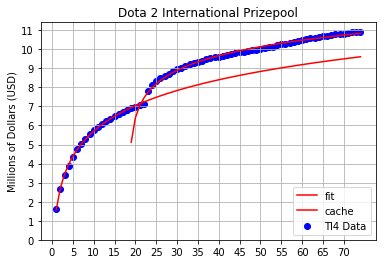

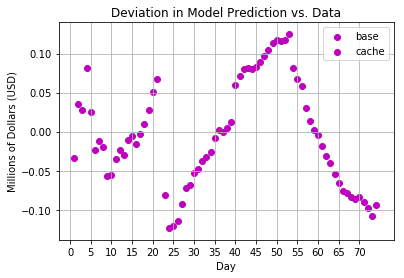

In [43]:
turning_point = base_fit(TI4_data)[2][crossover_point+1][1]

# Plotting routines for the data
plt.figure('TI4')
#plt.subplot(2,2,1)
plt.scatter(prepare_data(TI4_data)[0],prepare_data(TI4_data)[1],color='b',label='TI4 Data')
plt.plot(prepare_data(TI4_data)[0], base_log_func(prepare_data(TI4_data)[0], *base_fit(TI4_data)[0]), 'r-', label='fit')
plt.plot(prepare_data(TI4_data)[0], cache1(prepare_data(TI4_data)[0], *cache_fit(TI4_data)[0]), 'r-', label='cache')
plt.yticks(np.arange(0, max(prepare_data(TI4_data)[1])+1, 1))
#plt.tick_params(labelbottom='off')
plt.xticks(np.arange(0, max(prepare_data(TI4_data)[0])+1, 5))
plt.ylabel('Millions of Dollars (USD)')
plt.grid(True)
plt.title('Dota 2 International Prizepool')
plt.legend(loc='lower right')

# Plotting of the variance in data
#plt.subplot(2,2,2)
plt.figure('Deviation')
plt.ylabel('Millions of Dollars (USD)')
plt.xlabel('Day')
plt.title('Deviation in Model Prediction vs. Data')
plt.scatter(prepare_data(TI4_data)[0][:crossover_point], base_fit(TI4_data)[3][:crossover_point], color='m',label='base')
plt.xticks(np.arange(0, max(prepare_data(TI4_data)[0])+1, 5))
plt.scatter(prepare_data(TI4_data)[0][crossover_point+1:], cache_fit(TI4_data)[3][crossover_point+1:], color='m',label='cache')
plt.grid(True)
plt.legend(loc='best')

plt.show()

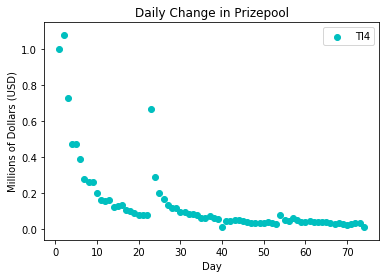

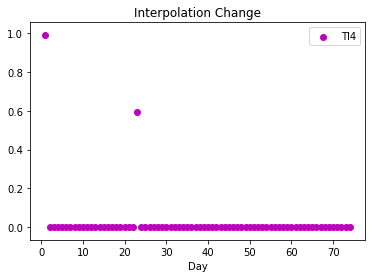

In [44]:
plt.figure('Daily Change')
#plt.subplot(2,1,1)
plt.ylabel('Millions of Dollars (USD)')
plt.xlabel('Day')
plt.title('Daily Change in Prizepool')
plt.scatter(prepare_data(TI4_data)[0],daily_growth(TI4_data),color='c',label='TI4')
plt.legend(loc='best')

#plt.subplot(2,1,2)
plt.figure('Interpolation Change')
plt.title('Interpolation Change')
plt.xlabel('Day')
plt.scatter(prepare_data(TI4_data)[0],accel_rate(TI4_data),color='m',label='TI4')
plt.legend(loc='best')

plt.show()